In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
# Add this near the top (right after the random seeds are set)
BATCH_SIZE_PHASE1 = 32
BATCH_SIZE_PHASE2 = 16

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# --- Cell 1: Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Cell 2: Point to your dataset inside Drive ---
import os

base_dir = "/content/drive/MyDrive/Images/Images"

appendicitis_path = os.path.join(base_dir, "Appendicitis_Images")
no_appendicitis_path = os.path.join(base_dir, "No_Appendicitis_Images")

# --- Quick sanity checks ---
print("Appendicitis path:", appendicitis_path, "| exists:", os.path.isdir(appendicitis_path))
print("No Appendicitis path:", no_appendicitis_path, "| exists:", os.path.isdir(no_appendicitis_path))

def count_images(p):
    if not os.path.isdir(p):
        return 0
    exts = (".bmp", ".jpg", ".jpeg", ".png")
    return sum(f.lower().endswith(exts) for f in os.listdir(p))

print("Found appendicitis images:", count_images(appendicitis_path))
print("Found no-appendicitis images:", count_images(no_appendicitis_path))


Mounted at /content/drive
Appendicitis path: /content/drive/MyDrive/Images/Images/Appendicitis_Images | exists: True
No Appendicitis path: /content/drive/MyDrive/Images/Images/No_Appendicitis_Images | exists: True
Found appendicitis images: 1339
Found no-appendicitis images: 382


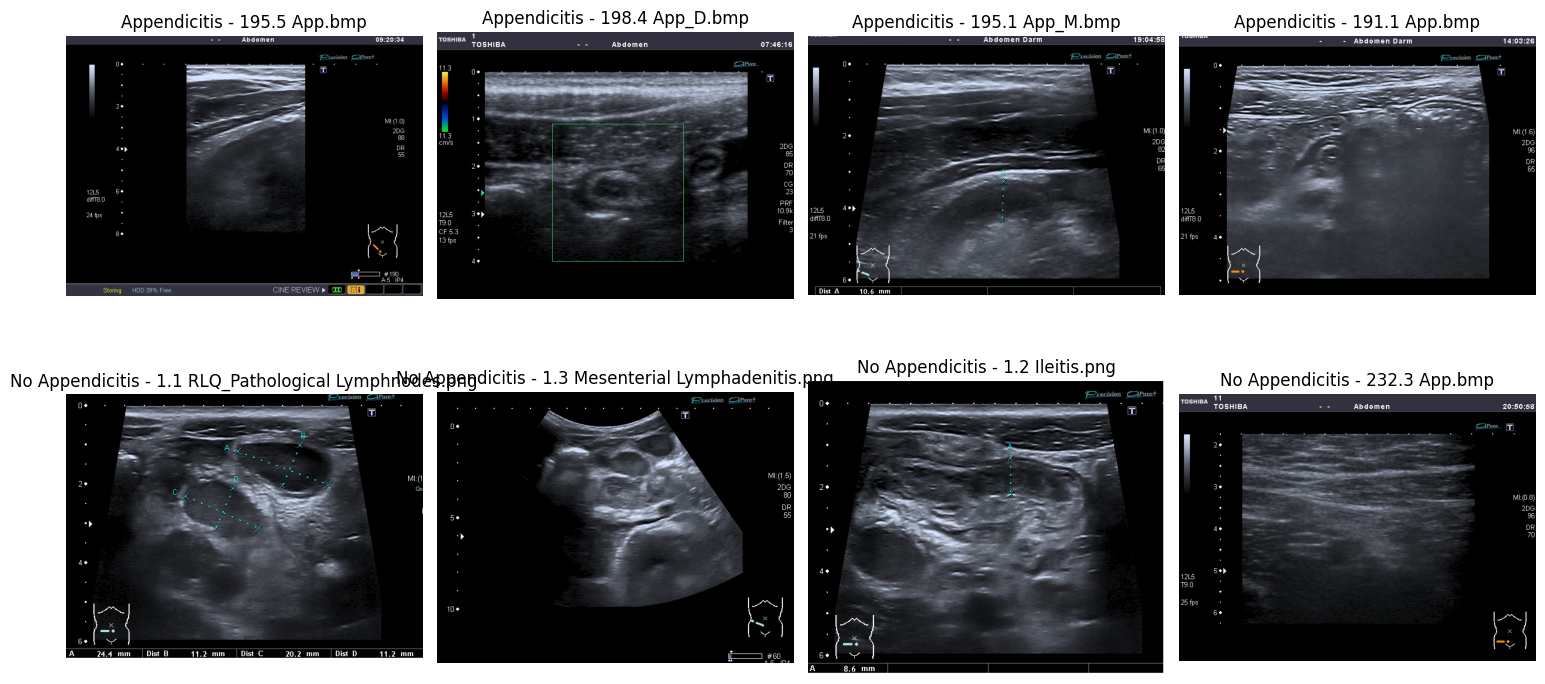

In [3]:
def plot_sample_images(num_samples=4):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))

    # Plot appendicitis samples
    appendicitis_files = [f for f in os.listdir(appendicitis_path)
                         if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
    for i in range(min(num_samples, len(appendicitis_files))):
        img_path = os.path.join(appendicitis_path, appendicitis_files[i])
        img = Image.open(img_path)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'Appendicitis - {appendicitis_files[i]}')
        axes[0, i].axis('off')

    # Plot no appendicitis samples
    no_appendicitis_files = [f for f in os.listdir(no_appendicitis_path)
                            if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
    for i in range(min(num_samples, len(no_appendicitis_files))):
        img_path = os.path.join(no_appendicitis_path, no_appendicitis_files[i])
        img = Image.open(img_path)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title(f'No Appendicitis - {no_appendicitis_files[i]}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images()

In [4]:
def load_and_preprocess_data(img_size=(224, 224)):
    """
    Load and preprocess images from both categories
    """
    images = []
    labels = []

    # Load appendicitis images (label = 1)
    print("Loading appendicitis images...")
    appendicitis_files = [f for f in os.listdir(appendicitis_path)
                         if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]

    for filename in appendicitis_files:
        try:
            img_path = os.path.join(appendicitis_path, filename)
            img = Image.open(img_path)

            # Convert to RGB if needed
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Resize image
            img = img.resize(img_size)
            img_array = np.array(img) / 255.0  # Normalize to [0,1]

            images.append(img_array)
            labels.append(1)  # Appendicitis

        except Exception as e:
            print(f"Error loading {filename}: {e}")

    # Load no appendicitis images (label = 0)
    print("Loading no appendicitis images...")
    no_appendicitis_files = [f for f in os.listdir(no_appendicitis_path)
                            if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]

    for filename in no_appendicitis_files:
        try:
            img_path = os.path.join(no_appendicitis_path, filename)
            img = Image.open(img_path)

            # Convert to RGB if needed
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Resize image
            img = img.resize(img_size)
            img_array = np.array(img) / 255.0  # Normalize to [0,1]

            images.append(img_array)
            labels.append(0)  # No appendicitis

        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(images), np.array(labels)

# Load the data
X, y = load_and_preprocess_data()
print(f"Loaded {len(X)} images with shape: {X.shape}")
print(f"Labels distribution: {np.bincount(y)}")

Loading appendicitis images...
Loading no appendicitis images...
Loaded 1721 images with shape: (1721, 224, 224, 3)
Labels distribution: [ 382 1339]


In [5]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Check class distribution
print("\nClass distribution:")
print(f"Train - Appendicitis: {np.sum(y_train)}, No appendicitis: {len(y_train) - np.sum(y_train)}")
print(f"Val - Appendicitis: {np.sum(y_val)}, No appendicitis: {len(y_val) - np.sum(y_val)}")
print(f"Test - Appendicitis: {np.sum(y_test)}, No appendicitis: {len(y_test) - np.sum(y_test)}")

Training set: 1204 images
Validation set: 258 images
Test set: 259 images

Class distribution:
Train - Appendicitis: 937, No appendicitis: 267
Val - Appendicitis: 201, No appendicitis: 57
Test - Appendicitis: 201, No appendicitis: 58


In [6]:
# === UNDERSAMPLING: downsample the majority class to match the minority ===
# This cell preserves downstream variable names so training code stays unchanged.
import numpy as np

print("\n[Undersampling] Checking training distribution...")
# Convert y_train to 1-D numpy array of ints if needed
y_arr = np.asarray(y_train).astype(np.int32).ravel()

# Support both array-of-paths and array-of-tensors for X_train
X_arr = np.asarray(X_train)

# Count per class
binc = np.bincount(y_arr)
print("[Undersampling] Original counts:", binc.tolist())

if len(binc) < 2:
    raise ValueError("Expected binary labels {0,1} in y_train for undersampling. Found only one class.")

# Split indices by class
idx0 = np.where(y_arr == 0)[0]
idx1 = np.where(y_arr == 1)[0]

# Determine minority size
n0, n1 = len(idx0), len(idx1)
if n0 == 0 or n1 == 0:
    raise ValueError(f"Cannot undersample with empty class: counts = [class0={n0}, class1={n1}]")

minority_n = min(n0, n1)
rng = np.random.default_rng(42)

# Downsample majority to match minority
if n0 > n1:
    keep0 = rng.choice(idx0, size=minority_n, replace=False)
    keep1 = idx1  # keep all minority
elif n1 > n0:
    keep1 = rng.choice(idx1, size=minority_n, replace=False)
    keep0 = idx0
else:
    # already balanced
    keep0, keep1 = idx0, idx1

keep_idx = np.concatenate([keep0, keep1], axis=0)
rng.shuffle(keep_idx)

# Build undersampled sets
X_train = X_arr[keep_idx]
y_train = y_arr[keep_idx]

# Optional: if your later code expects specific dtypes/shapes, you can adjust here
# y_train = y_train.astype(np.int32).reshape(-1)

print("[Undersampling] New counts:", np.bincount(y_train).tolist())
print("[Undersampling] Done. Downstream cells will now train on the undersampled train set.")



[Undersampling] Checking training distribution...
[Undersampling] Original counts: [267, 937]
[Undersampling] New counts: [267, 267]
[Undersampling] Done. Downstream cells will now train on the undersampled train set.


In [7]:
from tensorflow.keras.applications import DenseNet121

def create_densenet_model(input_shape=(224, 224, 3), num_classes=1):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = create_densenet_model()
model.summary()




29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,697,985 (29.37 MB)

 Trainable params: 658,433 (2.51 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

In [8]:
import tensorflow.keras.backend as K

def f1_score(y_true, y_pred):
    """Custom F1 score metric"""
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2*((precision_val*recall_val)/(precision_val+recall_val+K.epsilon()))

# Then recompile with this custom metric:
from keras.metrics import F1Score  # Keras 3

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        F1Score(name="f1", threshold=0.5, average="micro")
    ],
)


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Create callbacks (updated to monitor val_accuracy instead of val_f1_score)
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_appendicitis_model_undersampling.keras',
        monitor='val_accuracy',  # Changed from val_f1_score
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured!")

Callbacks configured!


In [10]:
# Convert labels to float32 to avoid dtype issues
y_train_float = y_train.astype(np.float32).reshape(-1, 1)
y_val_float   = y_val.astype(np.float32).reshape(-1, 1)

# First phase: Train only the top layers
print("Starting Phase 1: Training custom layers only...")
print(f"Base model trainable: {model.layers[0].trainable}")

history_phase1 = model.fit(
    x=X_train, y=y_train_float,
    batch_size=BATCH_SIZE_PHASE1,
    epochs=20,
    validation_data=(X_val, y_val_float),
    callbacks=callbacks,
    verbose=1
)


print("Phase 1 training completed!")

Starting Phase 1: Training custom layers only...
Base model trainable: False
Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5685 - f1: 0.5774 - loss: 0.7722 - precision: 0.5805 - recall: 0.5774  
Epoch 1: val_accuracy improved from -inf to 0.77907, saving model to best_appendicitis_model_undersampling.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.5685 - f1: 0.5766 - loss: 0.7726 - precision: 0.5798 - recall: 0.5763 - val_accuracy: 0.7791 - val_f1: 0.8758 - val_loss: 0.4978 - val_precision: 0.7791 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7450 - f1: 0.7559 - loss: 0.5401 - precision: 0.7408 - recall: 0.7724
Epoch 2: val_accuracy did not improve from 0.77907
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.7440 - f1: 0.7541 - loss: 0.5414 - precision: 0.7404 - recall: 0.7690 - val_accuracy: 0.7791 - val_f1: 0.8696 - val_loss: 0.5059 - val_precision: 0.8051 - val_recall: 0.9453 - learnin

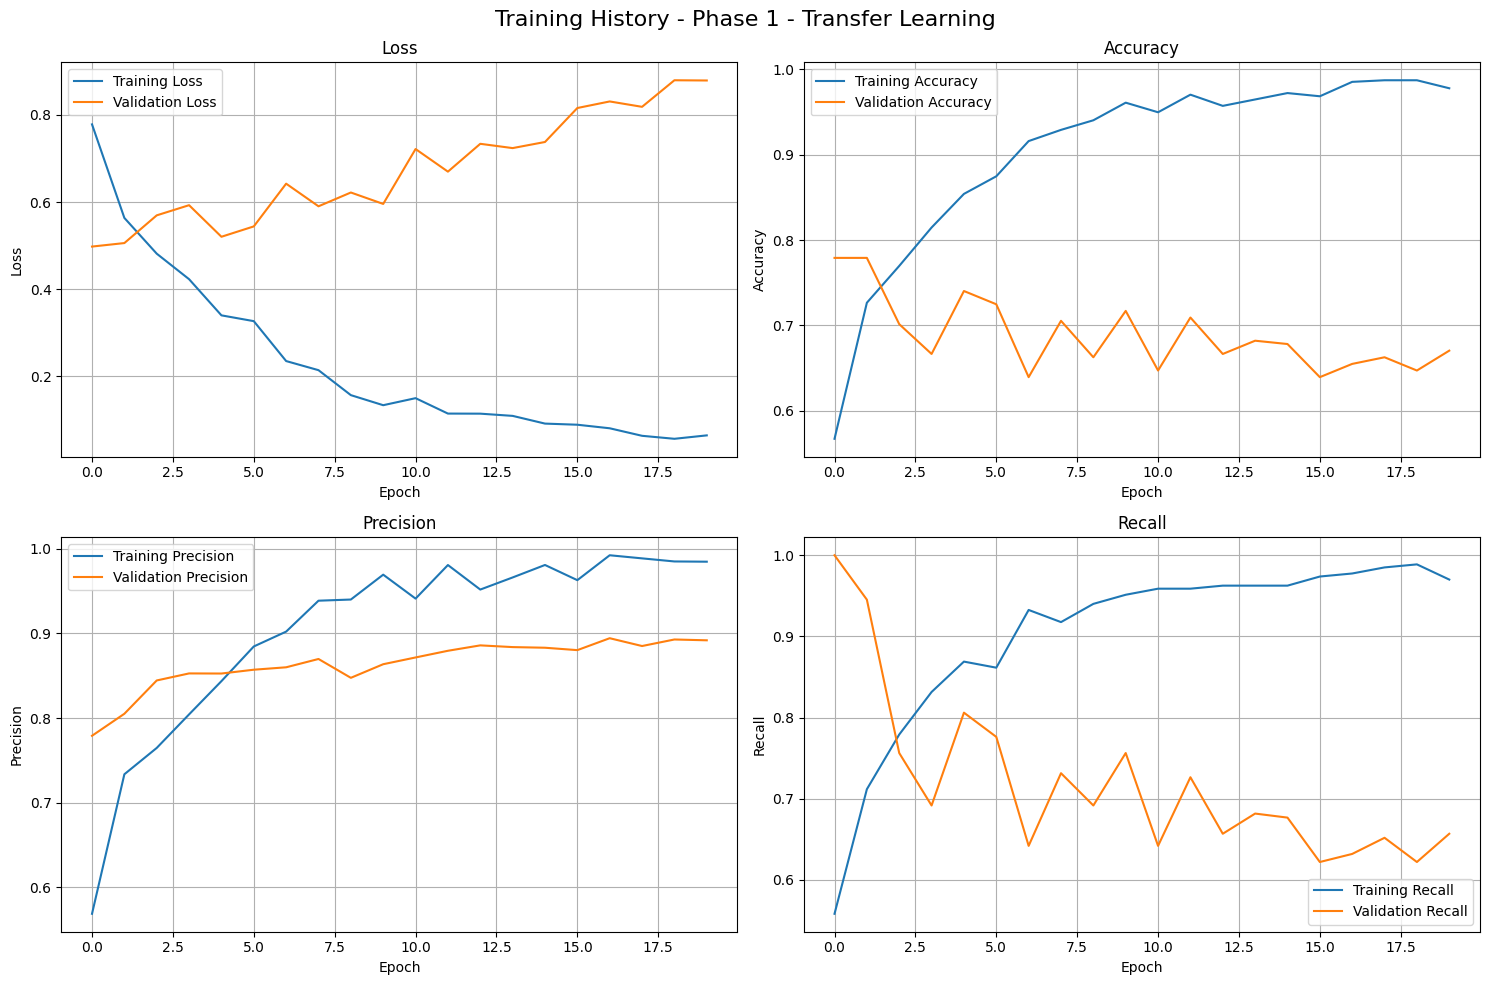

In [23]:
def plot_training_history(history, phase_name=""):
    """
    Plot training and validation metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Training History - {phase_name}', fontsize=16)

    # Plot loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plot accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot precision
    axes[1, 0].plot(history.history['precision'], label='Training Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Plot recall
    axes[1, 1].plot(history.history['recall'], label='Training Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot Phase 1 results
plot_training_history(history_phase1, "Phase 1 - Transfer Learning")

Phase 1 - Validation Set Evaluation:
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step

Classification Report:
                 precision    recall  f1-score   support

No Appendicitis       0.33      0.75      0.46        57
   Appendicitis       0.89      0.56      0.69       201

       accuracy                           0.60       258
      macro avg       0.61      0.66      0.57       258
   weighted avg       0.77      0.60      0.64       258



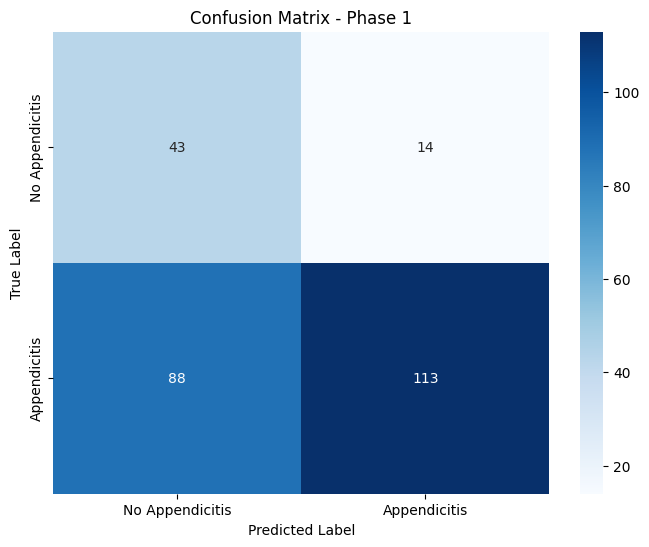


Sensitivity (Recall): 0.562
Specificity: 0.754


In [24]:
# Evaluate on validation set
print("Phase 1 - Validation Set Evaluation:")
val_predictions = model.predict(X_val)
val_predictions_binary = (val_predictions > 0.5).astype(int).ravel()

print("\nClassification Report:")
print(classification_report(y_val.ravel(), val_predictions_binary,
                          target_names=['No Appendicitis', 'Appendicitis']))

# Confusion Matrix
cm = confusion_matrix(y_val.ravel(), val_predictions_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Appendicitis', 'Appendicitis'],
            yticklabels=['No Appendicitis', 'Appendicitis'])
plt.title('Confusion Matrix - Phase 1')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print some metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"\nSensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

In [25]:
# Unfreeze the tail of DenseNet for fine-tuning
base_model = model.layers[0]
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

print("Fine-tuning setup:")
print(f"Total layers in base model: {len(base_model.layers)}")
print(f"Trainable layers: {sum(1 for layer in base_model.layers if layer.trainable)}")

# LOWER LR for fine-tuning and keep F1 metric
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        F1Score(name='f1', threshold=0.5, average='micro'),
    ]
)

print("Model recompiled for fine-tuning!")

Fine-tuning setup:
Total layers in base model: 427
Trainable layers: 4
Model recompiled for fine-tuning!


In [26]:
# Reset callbacks for phase 2
callbacks_phase2 = [

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    ),
    ModelCheckpoint(
        'best_appendicitis_model_phase2_undersampling.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

print("Starting Phase 2: Fine-tuning...")

history_phase2 = model.fit(
    x=X_train, y=y_train_float,
    batch_size=BATCH_SIZE_PHASE2,
    epochs=15,
    validation_data=(X_val, y_val_float),
    callbacks=callbacks_phase2,
    verbose=1
)

print("Phase 2 training completed!")

Starting Phase 2: Fine-tuning...
Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9869 - f1: 0.9872 - loss: 0.0603 - precision: 0.9931 - recall: 0.9814
Epoch 1: val_accuracy improved from -inf to 0.59302, saving model to best_appendicitis_model_phase2_undersampling.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9868 - f1: 0.9871 - loss: 0.0605 - precision: 0.9929 - recall: 0.9814 - val_accuracy: 0.5930 - val_f1: 0.6749 - val_loss: 1.4583 - val_precision: 0.8934 - val_recall: 0.5423 - learning_rate: 1.0000e-04
Epoch 2/15
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9943 - f1: 0.9943 - loss: 0.0410 - precision: 0.9982 - recall: 0.9905
Epoch 2: val_accuracy improved from 0.59302 to 0.60465, saving model to best_appendicitis_model_phase2_undersampling.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9940 - f1: 0.9940 - loss: 0.0415 - precision: 0.9977 - recall: 0.9904 - val_accuracy: 0.6047 - val_f1: 0.6890 - val_loss: 1.4484 - val_precisio

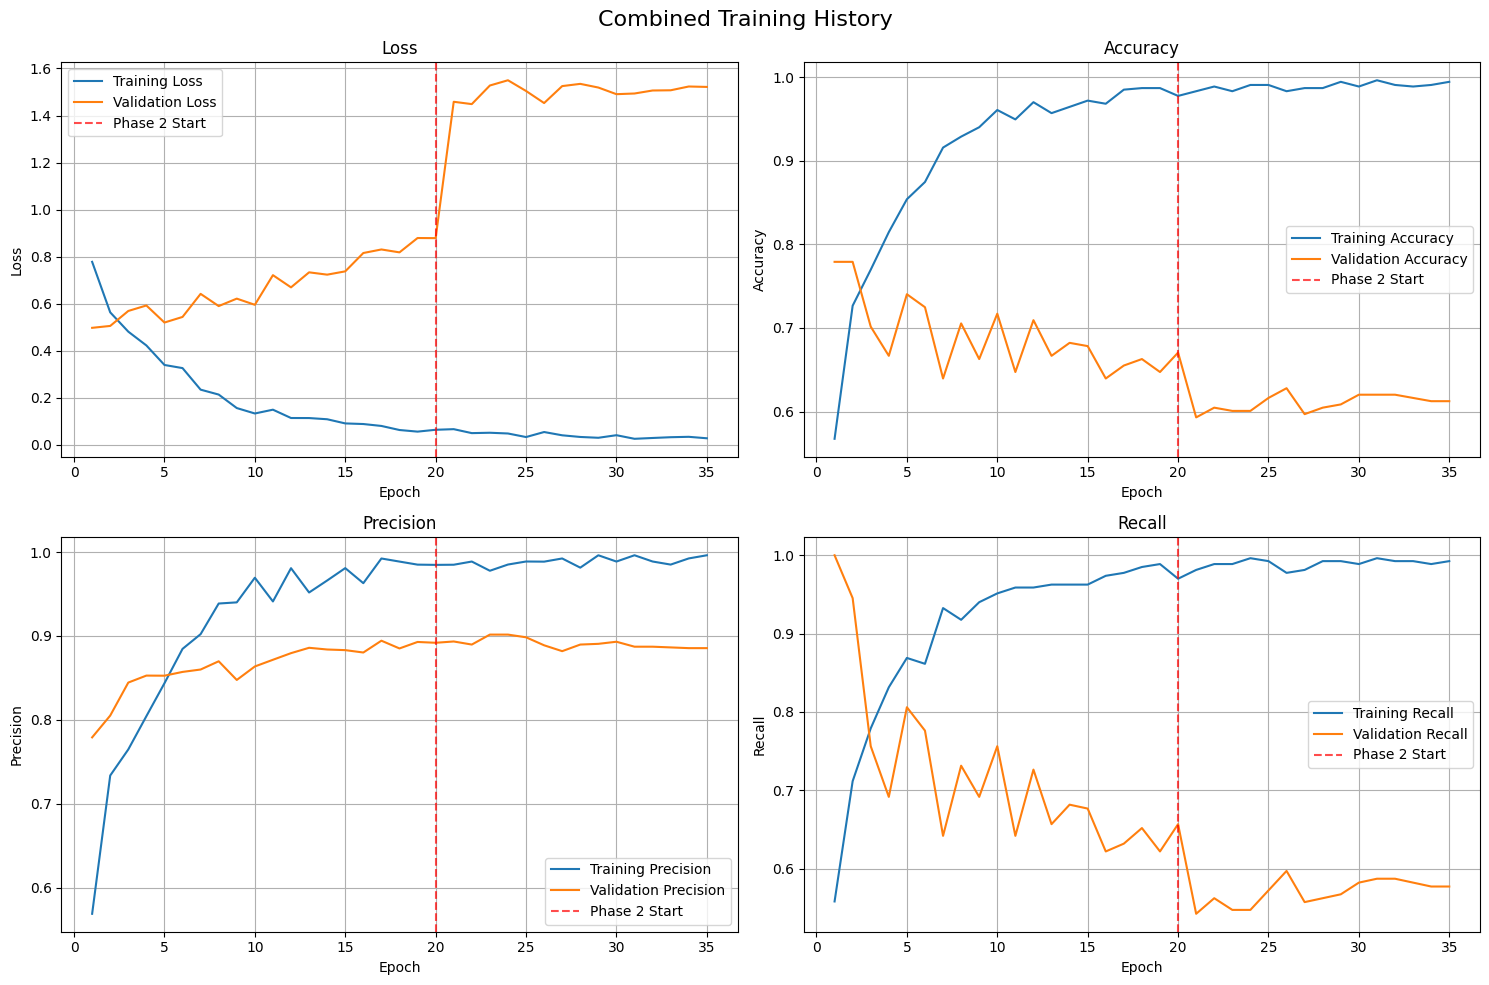

In [27]:
def plot_combined_history(hist1, hist2, phase1_name="Phase 1", phase2_name="Phase 2"):
    """
    Plot combined training history from both phases
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Combined Training History', fontsize=16)

    # Combine histories
    phase1_epochs = len(hist1.history['loss'])
    total_epochs = range(1, phase1_epochs + len(hist2.history['loss']) + 1)
    combined_loss = hist1.history['loss'] + hist2.history['loss']
    combined_val_loss = hist1.history['val_loss'] + hist2.history['val_loss']
    combined_acc = hist1.history['accuracy'] + hist2.history['accuracy']
    combined_val_acc = hist1.history['val_accuracy'] + hist2.history['val_accuracy']

    # Plot loss
    axes[0, 0].plot(total_epochs, combined_loss, label='Training Loss')
    axes[0, 0].plot(total_epochs, combined_val_loss, label='Validation Loss')
    axes[0, 0].axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7, label='Phase 2 Start')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plot accuracy
    axes[0, 1].plot(total_epochs, combined_acc, label='Training Accuracy')
    axes[0, 1].plot(total_epochs, combined_val_acc, label='Validation Accuracy')
    axes[0, 1].axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7, label='Phase 2 Start')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot precision
    combined_precision = hist1.history['precision'] + hist2.history['precision']
    combined_val_precision = hist1.history['val_precision'] + hist2.history['val_precision']
    axes[1, 0].plot(total_epochs, combined_precision, label='Training Precision')
    axes[1, 0].plot(total_epochs, combined_val_precision, label='Validation Precision')
    axes[1, 0].axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7, label='Phase 2 Start')
    axes[1, 0].set_title('Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Plot recall
    combined_recall = hist1.history['recall'] + hist2.history['recall']
    combined_val_recall = hist1.history['val_recall'] + hist2.history['val_recall']
    axes[1, 1].plot(total_epochs, combined_recall, label='Training Recall')
    axes[1, 1].plot(total_epochs, combined_val_recall, label='Validation Recall')
    axes[1, 1].axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7, label='Phase 2 Start')
    axes[1, 1].set_title('Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot combined results
plot_combined_history(history_phase1, history_phase2)

Final Evaluation on Test Set:
Test Loss: 1.3966
Test Accuracy: 0.6255
Test Precision: 0.8881
Test Recall: 0.5920
Test F1: 0.7104

Final Test Set Classification Report:
                 precision    recall  f1-score   support

No Appendicitis       0.34      0.74      0.47        58
   Appendicitis       0.89      0.59      0.71       201

       accuracy                           0.63       259
      macro avg       0.62      0.67      0.59       259
   weighted avg       0.77      0.63      0.66       259



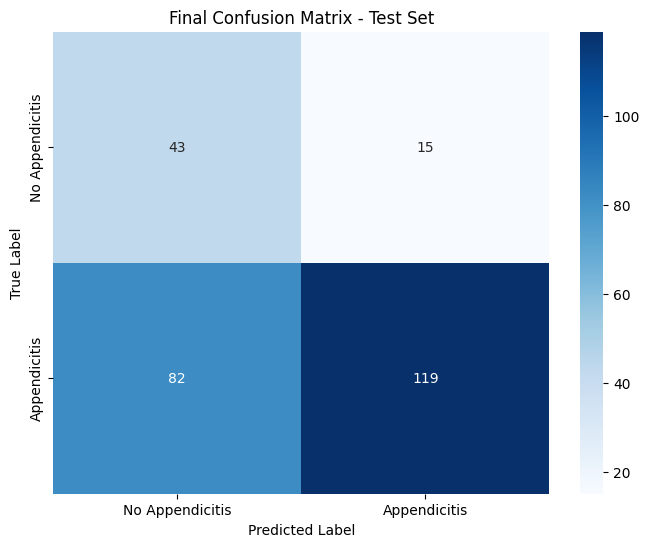


Final Test Metrics:
Sensitivity (Recall): 0.592
Specificity: 0.741
F1-Score: 0.710
Balanced Accuracy: 0.667


In [28]:
# Convert test labels to float32 (2D for Keras 3 F1)
y_test_float = y_test.astype(np.float32).reshape(-1, 1)

print("Final Evaluation on Test Set:")
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(X_test, y_test_float, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1: {test_f1:.4f}")

# Predictions → 1D for sklearn
test_predictions = model.predict(X_test, verbose=0)
test_predictions_binary = (test_predictions > 0.5).astype(int).ravel()

from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("\nFinal Test Set Classification Report:")
print(classification_report(y_test.ravel(), test_predictions_binary,
                            target_names=['No Appendicitis', 'Appendicitis']))

cm_test = confusion_matrix(y_test.ravel(), test_predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Appendicitis', 'Appendicitis'],
            yticklabels=['No Appendicitis', 'Appendicitis'])
plt.title('Final Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

tn, fp, fn, tp = cm_test.ravel()
final_sensitivity = tp / (tp + fn)
final_specificity = tn / (tn + fp)

# Use sklearn F1 on hard predictions (more accurate than 2*P*R/(P+R) from averaged metrics)
final_f1 = f1_score(y_test.ravel(), test_predictions_binary)

print(f"\nFinal Test Metrics:")
print(f"Sensitivity (Recall): {final_sensitivity:.3f}")
print(f"Specificity: {final_specificity:.3f}")
print(f"F1-Score: {final_f1:.3f}")
print(f"Balanced Accuracy: {(final_sensitivity + final_specificity) / 2:.3f}")



✅ Additional Evaluation Metrics:
Macro F1: 0.5902
AUC (ROC): 0.7154


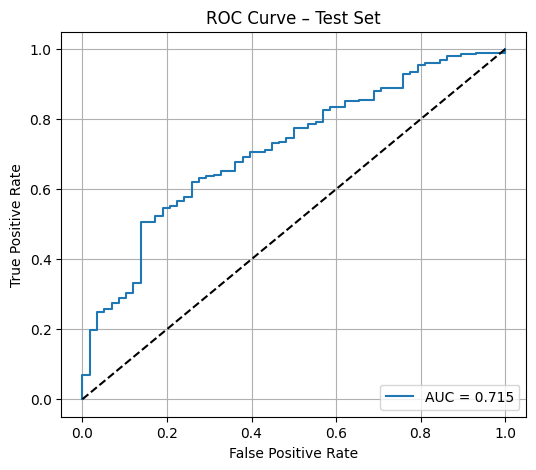

In [30]:
# === Additional Metrics: Macro F1 and AUC (fixed) ===
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Ensure shapes are right
y_true = y_test.ravel()
# test_predictions is (N,1); squeeze to (N,)
y_prob = np.asarray(test_predictions).ravel()
y_pred = test_predictions_binary.ravel()

# Macro-F1: equal weight to both classes (uses hard labels)
macro_f1 = f1_score(y_true, y_pred, average='macro')

# AUC: must use probabilities, not hard labels
auc = roc_auc_score(y_true, y_prob)

print("\n✅ Additional Evaluation Metrics:")
print(f"Macro F1: {macro_f1:.4f}")
print(f"AUC (ROC): {auc:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Test Set"); plt.legend(loc="lower right"); plt.grid(True)
plt.show()


In [31]:
# Save the complete model
model.save('final_appendicitis_densenet121_undersampling.keras')
print("Model saved as 'final_appendicitis_densenet121_undersampling.keras'")

# Save model architecture as JSON
model_json = model.to_json()
with open("appendicitis_model_architecture_undersampling.json", "w") as json_file:
    json_file.write(model_json)

# Save only the weights
model.save_weights("appendicitis_model_weights_undersampling.weights.h5")
print("Model architecture and weights saved separately")

Model saved as 'final_appendicitis_densenet121_undersampling.keras'
Model architecture and weights saved separately


In [32]:
import os, shutil

# === Define your model-specific subfolder ===
model_name = "DenseNet121_undersampling"  # 👈 change for each model if needed

# === Create the nested directory in Drive ===
save_dir = f"/content/drive/MyDrive/Appendicitis_Models/{model_name}"
os.makedirs(save_dir, exist_ok=True)

# === Copy all your key files into that subfolder ===
for f in [
    "final_appendicitis_densenet121_undersampling.keras",
    "appendicitis_model_weights_undersampling.weights.h5",
    "appendicitis_model_architecture_undersampling.json"
]:
    if os.path.exists(f):
        shutil.copy(f, save_dir)
        print(f"✅ Saved: {f} → {save_dir}")
    else:
        print(f"⚠️ File not found: {f}")

print(f"\nAll files safely stored in: {save_dir}")


✅ Saved: final_appendicitis_densenet121_undersampling.keras → /content/drive/MyDrive/Appendicitis_Models/DenseNet121_undersampling
✅ Saved: appendicitis_model_weights_undersampling.weights.h5 → /content/drive/MyDrive/Appendicitis_Models/DenseNet121_undersampling
✅ Saved: appendicitis_model_architecture_undersampling.json → /content/drive/MyDrive/Appendicitis_Models/DenseNet121_undersampling

All files safely stored in: /content/drive/MyDrive/Appendicitis_Models/DenseNet121_undersampling


In [33]:
def predict_appendicitis(image_path, model_path, threshold=0.5):
    """
    Predict appendicitis for a new ultrasound image

    Args:
        image_path: Path to the image file
        model_path: Path to the saved model file (.h5 or .keras)
        threshold: Decision threshold (default 0.5)

    Returns:
        Dictionary with prediction results
    """
    try:
        # Load the model from file
        loaded_model = tf.keras.models.load_model(model_path)

        # Load and preprocess image
        img = Image.open(image_path)

        # Convert to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Resize to model input size
        img = img.resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make prediction
        prediction_prob = loaded_model.predict(img_array, verbose=0)[0][0]
        prediction_binary = int(prediction_prob > threshold)

        # Prepare result
        result = {
            'image_path': image_path,
            'probability': float(prediction_prob),
            'prediction': 'Appendicitis' if prediction_binary == 1 else 'No Appendicitis',
            'confidence': float(max(prediction_prob, 1 - prediction_prob)),
            'threshold_used': threshold
        }

        return result

    except Exception as e:
        return {'error': str(e), 'image_path': image_path}

In [34]:
# Create a simple deployment script
deployment_code = '''
import numpy as np
from PIL import Image
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('final_appendicitis_densenet121_undersampling.keras')

def predict_single_image(image_path, threshold=0.5):
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction_prob = model.predict(img_array, verbose=0)[0][0]
    prediction = "Appendicitis" if prediction_prob > threshold else "No Appendicitis"
    confidence = max(prediction_prob, 1 - prediction_prob)

    return {
        'prediction': prediction,
        'probability': float(prediction_prob),
        'confidence': float(confidence)
    }
'''


with open('deploy_model.py', 'w') as f:
    f.write(deployment_code)

print("Deployment script created as 'deploy_model.py'")

Deployment script created as 'deploy_model.py'


In [35]:
result = predict_appendicitis(
    "processed_data/doesnt_have_appendicitis/352.2 App_D.bmp",
    "final_appendicitis_densenet121_undersampling.keras"
)
print("Prediction result:", result)


Prediction result: {'error': "[Errno 2] No such file or directory: 'processed_data/doesnt_have_appendicitis/352.2 App_D.bmp'", 'image_path': 'processed_data/doesnt_have_appendicitis/352.2 App_D.bmp'}
